# DP DEMO

In [1]:
import matplotlib.pyplot as plt
import tqdm

In [2]:
from align_new_audio_to_video import *

In [3]:
source_video_file = '../../dp/CV_05_C4W1L05_000001_to_000011.mp4'                                                                                 
target_dialogue_file = '../../dp/CV_05_C4W1L05_000001_to_000011_ma.mp3'

# Pre-processing

In [5]:
# Read video
video_reader = imageio.get_reader(source_video_file)
video_fps = video_reader.get_meta_data()['fps']

# Write audio from video
source_audio_file = '/tmp/source_audio.wav'
ret = subprocess.call(['ffmpeg', '-loglevel', 'error', '-i', source_video_file, '-vn', '-y', '-codec:a', 'pcm_s16le', '-ar', '16000', '-ac', '1', '-f', 'wav', source_audio_file])

# Target dialogue .wav
target_audio_file = '/tmp/target_audio.wav'
ret = subprocess.call(['ffmpeg', '-loglevel', 'error', '-i', target_dialogue_file, '-vn', '-y', '-codec:a', 'pcm_s16le', '-ar', '16000', '-ac', '1', '-f', 'wav', target_audio_file])

frame_length = 0.025
frame_stride = 0.010
num_cepstral = 13
num_filters = 40

In [27]:
print(video_reader.get_meta_data())

{'plugin': 'ffmpeg', 'nframes': 301, 'ffmpeg_version': '3.4.2 built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)', 'fps': 30.0, 'source_size': (1152, 720), 'size': (1152, 720), 'duration': 10.02}


# 1. Using Mine

In [6]:
source_audio_fs, source_audio = scipy.io.wavfile.read(source_audio_file)
if len(source_audio.shape) > 1:
    source_audio = source_audio[:, 0]

target_audio_fs, target_audio = scipy.io.wavfile.read(target_audio_file)
if len(target_audio.shape) > 1:
    target_audio = target_audio[:, 0]

In [7]:
print(source_audio.shape, source_audio_fs, target_audio.shape, target_audio_fs)

(160125,) 16000 (177984,) 16000


In [35]:
mapped_target_audio_frames_of_source_audio_frames, \
            mapped_source_audio_frames_of_target_audio_frames = my_dynamic_programming(source_audio, source_audio_fs,
                                                                                       target_audio, target_audio_fs,
                                                                                       verbose=True)

Converting source and target audio into MFCC features with frame_length 0.025 , frame_stride 0.01 , num_cepstral 13 , num_filters 40
Doing dynamic programming between source and target audio


100%|██████████| 999/999 [00:33<00:00, 29.64it/s]


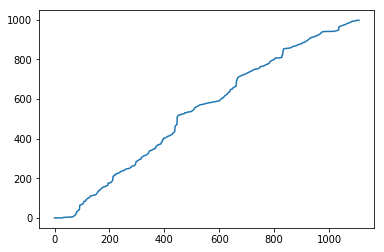

In [36]:
plt.plot(np.arange(len(mapped_source_audio_frames_of_target_audio_frames)), mapped_source_audio_frames_of_target_audio_frames)

In [37]:
# CONVERT AUDIO MAPPING TO VIDEO MAPPING, i.e. mapped_source_video_frames_of_target_video_frames
# Get source videos frames of the target audio frames
mapped_source_video_frames_of_target_audio_frames = mapped_source_audio_frames_of_target_audio_frames * frame_stride * video_fps
# Calculate the number of target video frames (from the number of audio frames and fps)
num_of_target_video_frames = round( len(mapped_source_video_frames_of_target_audio_frames) * frame_stride * video_fps )
# Make a linear mapping from the target audio frames to target video frames
target_audio_frames_idx_of_target_video_frames = np.round(np.linspace(0,
                                                                      len(mapped_source_video_frames_of_target_audio_frames)-1,
                                                                      num_of_target_video_frames)).astype(int)
# Select the source video frames corresponding to each target video frame
mapped_source_video_frames_of_target_video_frames = np.floor(mapped_source_video_frames_of_target_audio_frames[target_audio_frames_idx_of_target_video_frames]).astype(int)

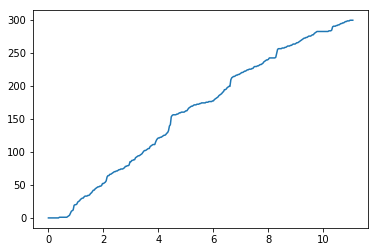

In [38]:
plt.plot(np.arange(len(mapped_source_video_frames_of_target_video_frames))/video_fps, mapped_source_video_frames_of_target_video_frames)

# 2. Using dwe's

https://github.com/dpwe/dp_python/blob/master/dp.ipynb

In [12]:
import librosa
import dpcore

# Mirror matlab example from http://www.ee.columbia.edu/ln/rosa/matlab/dtw/
d1, sr = librosa.load(source_audio_file, sr=None)
d2, sr = librosa.load(target_audio_file, sr=None)
# Calculate their short-time Fourier transforms
D1C = librosa.stft(d1, n_fft=512, hop_length=128)
D2C = librosa.stft(d2, n_fft=512, hop_length=128)
# We'll use the magnitudes to calculate similarity (ignore phase)
D1 = np.abs(D1C)
D2 = np.abs(D2C)

In [13]:
print(d1.shape, d2.shape)
print(D1.shape, D2.shape)

(160125,) (177984,)
(257, 1251) (257, 1391)


In [31]:
print(len(d1)/sr*video_fps, len(d2)/sr*video_fps)

300.234375 333.72


In [14]:
# Cosine similarity matrix (slow one-liner)
# Each cell SM[i,j] is the cosine similarity between D1[:,i] and D2[:,j]
# i.e. the inner product of the two unit-normalized feature vectors
SM = np.array([[np.sum(a*b)/np.sqrt(np.sum(a**2)*np.sum(b**2)) for b in D2.T] for a in tqdm(D1.T)])

  0%|          | 0/1251 [00:00<?, ?it/s]/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in float_scalars
  after removing the cwd from sys.path.
100%|██████████| 1251/1251 [01:29<00:00, 13.91it/s]


In [30]:
SM.shape

(1251, 1391)

In [15]:
import time
s = time.time()

# Find the minimum-cost path.  We use 1-SM so that cosine similarity == 1 -> cost = 0
# penalty is the additional cost incurred by non-diagonal steps (promotes diagonality)
localcost = np.array(1.0-SM, order='C', dtype=float)
p, q, C, phi = dpcore.dp(localcost, penalty=0.1)
# p and q are vectors giving the row and column indices along the best path
# C returns the full minimum-cost matrix, and phi is the full traceback matrix

e = time.time()
print(e-s, "seconds")

37.774259090423584 seconds


/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  after removing the cwd from sys.path.
/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  


[0, 1391, 0, 1251]

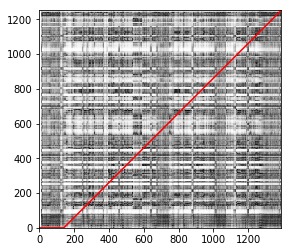

In [16]:
# Plot the best path on top of local similarity matrix
fig, ax = plt.subplots()
ax.imshow(SM, interpolation='none', cmap='binary')
ax.hold(True)
ax.plot(q,p,'-r')
ax.hold(False)
ax.axis([0, np.size(D2, axis=1), 0, np.size(D1, axis=1)])

In [18]:
print(len(p), len(q))

1391 1391


/users/voleti.vikram/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


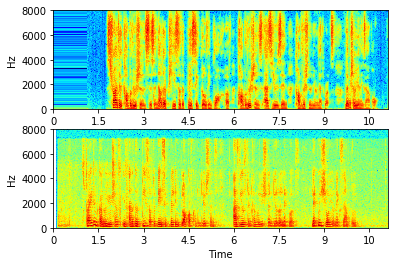

In [33]:
import librosa.display
plt.subplot(2,1,1)
librosa.display.specshow(20*np.log10(D1[:, p]), sr=sr, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')
plt.subplot(2,1,2)
librosa.display.specshow(20*np.log10(D2[:, q]), sr=sr, hop_length=128, y_axis="linear", x_axis="time", cmap='jet')

In [24]:
mapped_source_audio_frames_of_target_audio_frames = np.array(p).astype('float')

In [25]:
# CONVERT AUDIO MAPPING TO VIDEO MAPPING, i.e. mapped_source_video_frames_of_target_video_frames
# Get source videos frames of the target audio frames
mapped_source_video_frames_of_target_audio_frames = mapped_source_audio_frames_of_target_audio_frames * frame_stride * video_fps
# Calculate the number of target video frames (from the number of audio frames and fps)
num_of_target_video_frames = round( len(mapped_source_video_frames_of_target_audio_frames) * frame_stride * video_fps )
# Make a linear mapping from the target audio frames to target video frames
target_audio_frames_idx_of_target_video_frames = np.round(np.linspace(0,
                                                                      len(mapped_source_video_frames_of_target_audio_frames)-1,
                                                                      num_of_target_video_frames)).astype(int)
# Select the source video frames corresponding to each target video frame
mapped_source_video_frames_of_target_video_frames = np.floor(mapped_source_video_frames_of_target_audio_frames[target_audio_frames_idx_of_target_video_frames]).astype(int)

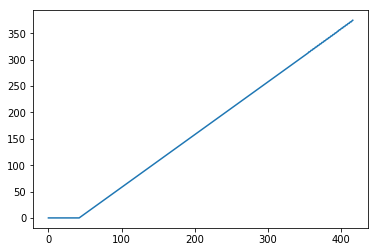

In [26]:
plt.plot(np.arange(len(mapped_source_video_frames_of_target_video_frames)), mapped_source_video_frames_of_target_video_frames)